# Machine Learning - Linear Regression

Credits to: 
* Kaggle House Prices Competition Dataset.- https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques
* Notes from Ames Dataset creator, Dean De Cock: http://jse.amstat.org/v19n3/decock.pdf
* Code: https://www.kaggle.com/code/apapiu/regularized-linear-models/notebook
* Python Data Science Handbook by Jake VanderPlas

Goal: Predict housing prices with Multiple Linear Regression. 

* Multiple Linear Regression: a regression with multiple explanatory variables, but only one dependent variable. 

Outline: 
1. Read in Packages and Training dataset for Linear Regression model
2. Preprocessing / Feature Engineering
3. Split Training dataset to test/validate
4. Create Lasso Regression ($L_1$ regularization) Model
5. Evaluate the Model

Quick Machine learning process (remember highly iterative throughout these steps):
1. Choose a class of model
2. Choose hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

## Import packages

In [1]:
# import packages
import pandas as pd
import numpy as np

from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns',200)
# df.columns = df.columns.str.lower()

## Read in data

In [3]:
# import test dataset

train = pd.read_csv("/Users/abeygailpanganiban/Desktop/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/Users/abeygailpanganiban/Desktop/house-prices-advanced-regression-techniques/test.csv")

In [4]:
# check for duplicates

idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsTotal - idsUnique

0

#### Taking a look at outliers in our dataset

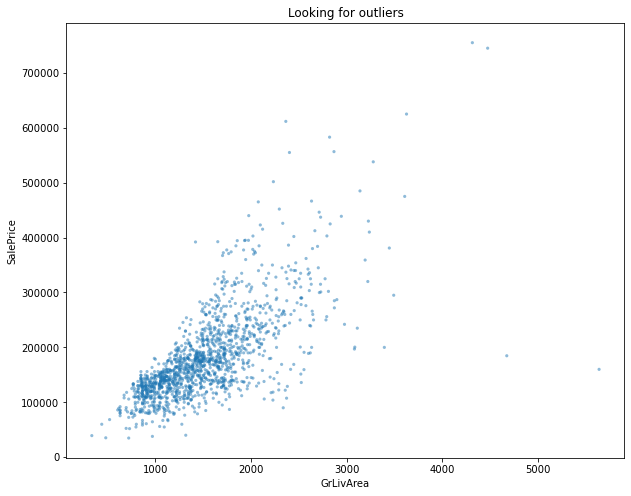

In [5]:
# start with outliers
plt.rcParams['figure.figsize'] = (10,8)

plt.scatter(train['GrLivArea'], train['SalePrice'], alpha = 0.5,s=10, edgecolors='none')
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

plt.show()

Manually removing an upper threshold of homes that are greater than 4000 sq.ft

In [6]:
train['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

In [7]:
# Define upper limit for GrLivArea

upper_threshold_sqft = 4000

In [8]:
# remove really large houses, these are outliers!

train = train[train.GrLivArea < upper_threshold_sqft]

## Preprocessing

Preferably, we would create a Feature Pipeline to prevent data leakage between our train and test datasets from the Kaggle competiton, but this will be a quick and dirty start. 

In [9]:
#Concatenate both Train and Test so we clean the same way

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [10]:
# Check on shapes of datasets

print(train.shape)
print(test.shape)
print(all_data.shape)

(1456, 81)
(1459, 80)
(2915, 79)


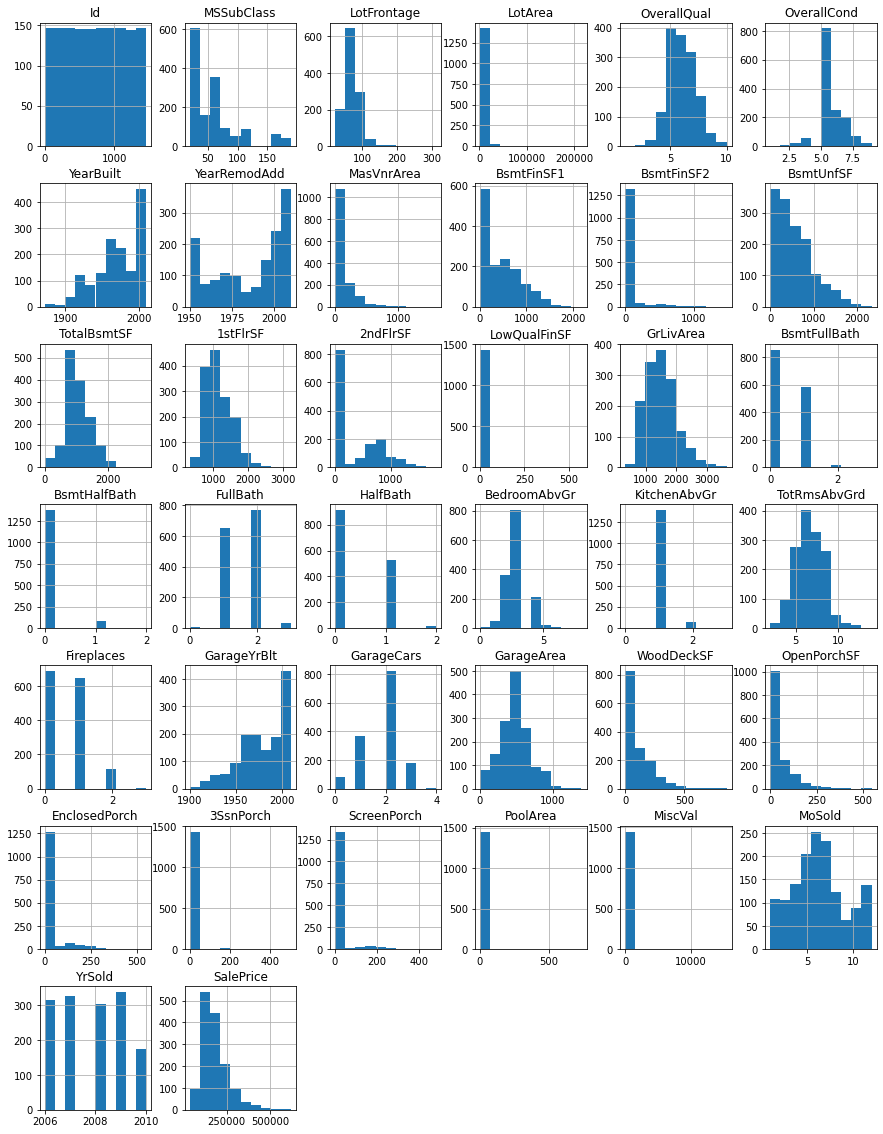

In [11]:
# Take a look distributions of numerical variables

plt.rcParams['figure.figsize'] = (15.0, 20.0)

train.hist()
plt.show()

#### Looking through histograms of variables in train set to consider as candidates for log transform or feature scaling.



For Review: (from https://www.youtube.com/watch?v=mnKm3YP56PY)
* Normalization (Min-Max Normalization): help scale down features from 0-1 
    * `from sklearn.preprocessing import MinMaxScaler`
    
    
* Standardization (Z-Score Normalization): help scale down features to standard deviations
    * `from sklearn.preprocessing import StandardScaler`
    
 Feature scaling important in Linear Regression when we try to find global minimum from gradient descent. 

#### Log Transform SalePrice

Taking logs of SalePrice means that errors in predicting expensive houses and cheap houses will affet the result equally.

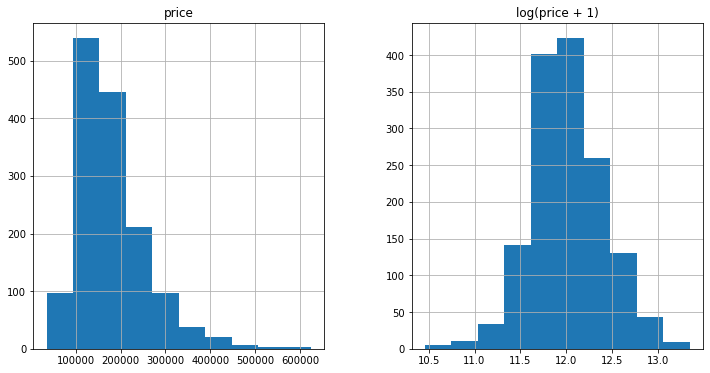

In [12]:
# Observe SalePrice 

plt.rcParams['figure.figsize'] = (12.0, 6.0)

prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

plt.show()

In [13]:
# Log transform the target for better scoring later in our model
# reminder that SalePrice is not included in PreProcessing with All_data

train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

In [14]:
# #log transform skewed numeric features:

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

### One-Hot Encode Categorical Features

Need to see how many categorical variables there are, we'll have to transform these using one hot encoding.


In [15]:
def check_cat_features(s):
    cols = s.columns
    
    numerical_columns = s._get_numeric_data().columns
    categorical_columns = list(set(cols) - set(numerical_columns))
    
    print("there are " + str(len(categorical_columns)) + " categorical columns.")
    print(categorical_columns)

In [16]:
check_cat_features(all_data)

there are 43 categorical columns.
['HouseStyle', 'Electrical', 'Exterior2nd', 'Condition2', 'KitchenQual', 'LotConfig', 'GarageQual', 'MSZoning', 'Heating', 'PavedDrive', 'PoolQC', 'GarageFinish', 'Utilities', 'GarageCond', 'SaleCondition', 'GarageType', 'Alley', 'BsmtQual', 'RoofStyle', 'RoofMatl', 'LandSlope', 'CentralAir', 'LandContour', 'BsmtCond', 'SaleType', 'ExterCond', 'Foundation', 'Fence', 'BsmtFinType2', 'Street', 'BsmtFinType1', 'Condition1', 'Neighborhood', 'BsmtExposure', 'ExterQual', 'HeatingQC', 'MasVnrType', 'FireplaceQu', 'Exterior1st', 'BldgType', 'Functional', 'MiscFeature', 'LotShape']


In [17]:
# one-hot encoding with `get_dummies`

all_data = pd.get_dummies(all_data, dummy_na=False)

In [18]:
#Check to make sure there are 0 categorical columns left after get_dummies

check_cat_features(all_data)

there are 0 categorical columns.
[]


### Numerical features that are categories

TODO: 
* month values into circle (keep year as it is)

## Fit Model to Training Data

Create Matrices from all_data after proprocessing back into give Train and Test dataset.

In [19]:
#creating matrices for sklearn:

X_train_pd = all_data.iloc[:train.shape[0]]
X_test_pd = all_data.iloc[train.shape[0]:]
y_train = train.SalePrice

In [20]:
# Checking for Categorical Columns in our Train dataset
check_cat_features(X_train_pd)

there are 0 categorical columns.
[]


#### Handle Missing Variables and Normalize in the array

In [21]:
#Handle Missing Variables, which also converts Pandas DataFrame into Numpy Array

from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train_pd)
X_train

array([[4.11087386, 4.18965474, 9.04204006, ..., 0.        , 1.        ,
        0.        ],
       [3.04452244, 4.39444915, 9.16962254, ..., 0.        , 1.        ,
        0.        ],
       [4.11087386, 4.2341065 , 9.32821229, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [4.26267988, 4.20469262, 9.10974626, ..., 0.        , 1.        ,
        0.        ],
       [3.04452244, 4.2341065 , 9.18173511, ..., 0.        , 1.        ,
        0.        ],
       [3.04452244, 4.33073334, 9.20412107, ..., 0.        , 1.        ,
        0.        ]])

In [22]:
from sklearn.preprocessing import MinMaxScaler

#let's normalzie the data! (rough)

norm = MinMaxScaler().fit(X_train)

X_train = norm.transform(X_train)
# X_test = norm.transform(X_test)

## Lasso Regression Model 

In [23]:
#fit the model! with tol and max_iter
model_lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.05, 0.001, 0.0005], tol=1e-3, max_iter=2000).fit(X_train, y_train)


In [24]:
#get our predicted values

y_pred = model_lasso.predict(X_train)

## Evaluate Model

In [25]:
#mean squared error
from sklearn.metrics import mean_squared_error
def rmse_cv(y_true, y_pred):
    rmse= mean_squared_error(y_true, y_pred, squared=False)
    return rmse

In [26]:
rmse_cv(y_train, y_pred)

0.09969907792829699

#### Observe Features used in model

In [27]:
coef = pd.Series(model_lasso.coef_, index = X_train_pd.columns)

In [28]:
#how many variables were chosen

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 104 variables and eliminated the other 183 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

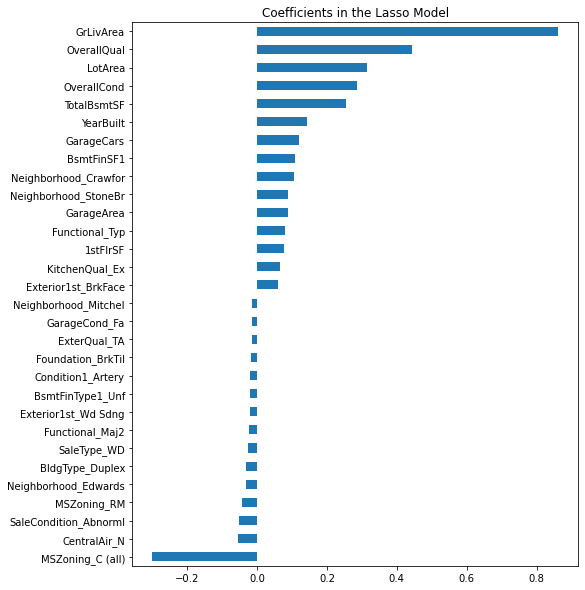

In [29]:
imp_coef = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])




plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

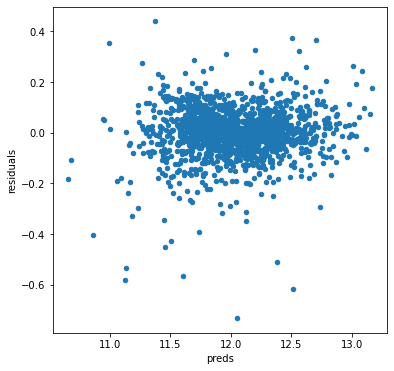

In [98]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Model did quite well around the 11.5 - 13.0 range, and weak to predict on the lower ends of SalePrice.

# Conclusion: 
* other things can be done like using different models that are combinations of weak learners (gradient boosted decision trees)
